<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/04%20-%20ML/06_ts_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install statsmodels>=0.14
#!pip install pandas==2.1.4 --q
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install etna --q
from etna.datasets import TSDataset
from etna.analysis.outliers import get_anomalies_prediction_interval
from etna.analysis import plot_anomalies
from etna.analysis import plot_trend
from etna.analysis import plot_backtest
from etna.analysis import acf_plot
from etna.transforms import LinearTrendTransform, LagTransform, PredictionIntervalOutliersTransform, TimeSeriesImputerTransform

from etna.models import ProphetModel
from etna.models import CatBoostPerSegmentModel
from etna.models import LinearPerSegmentModel
from etna.models import AutoARIMAModel
from etna.models import NaiveModel

from etna.pipeline import Pipeline
from etna.metrics import SMAPE

from statsmodels.tsa.stattools import adfuller

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install clickhouse-driver --q
from clickhouse_driver import Client
from google.colab import userdata
import warnings
warnings.filterwarnings('ignore')

In [ ]:

# Реквизиты для подключения к БД
user = 'hardda_student_alekse-fomin'
password = userdata.get('HA[hardda_student_alekse-fomin]')

host='clickhouse.lab.karpov.courses'
port=9000
database_r='hardda' # БД с правами только на чтение

In [ ]:
# Создаем соединение с БД ClickHouse
client_r = Client(host=host, port=port, user=user,
                password=password, database=database_r)

## Задание 1. Первичный анализ (1/3)
Из доступной в ClickHouse таблицы `live_adverts` выгрузите данные по количеству активных уникальных объявлений на каждый день.

За какой промежуток времени нам доступны данные?

In [ ]:
#
sql = """
SELECT
  execution_date :: date as timestamp,
  count(distinct advert_id) as target
FROM
  hardda.live_adverts
GROUP BY
  execution_date :: date
ORDER BY
  1
"""
result, columns = client_r.execute(sql, with_column_types=True)
data = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])


In [ ]:
data['timestamp'] = pd.to_datetime(data.timestamp)

In [ ]:
print(f"нам доступны данные за промежуток с {data.timestamp.min().strftime('%Y-%m-%d')} по {data.timestamp.max().strftime('%Y-%m-%d')}")

нам доступны данные за промежуток с 2022-02-01 по 2023-01-31


## Задание 1. Первичный анализ (2/3)
Есть ли пропущенные значения?

In [ ]:
print(f"в датасете пропущено { (data.timestamp.max() - data.timestamp.min()).days + 1 - len(data)} дней")


в датасете пропущено 0 дней


## Задание 1. Первичный анализ (3/3)
Преобразуйте датафрейм в объект класса etna.datasets.TSDataset и изобразите временной ряд на графике.

В какую дату количество объявлений экстремально низкое? Введите дату в формате YYYY-MM-DD

In [ ]:
data["segment"] = 'main'

In [ ]:
data_dayly = TSDataset(TSDataset.to_dataset(data), freq='D')

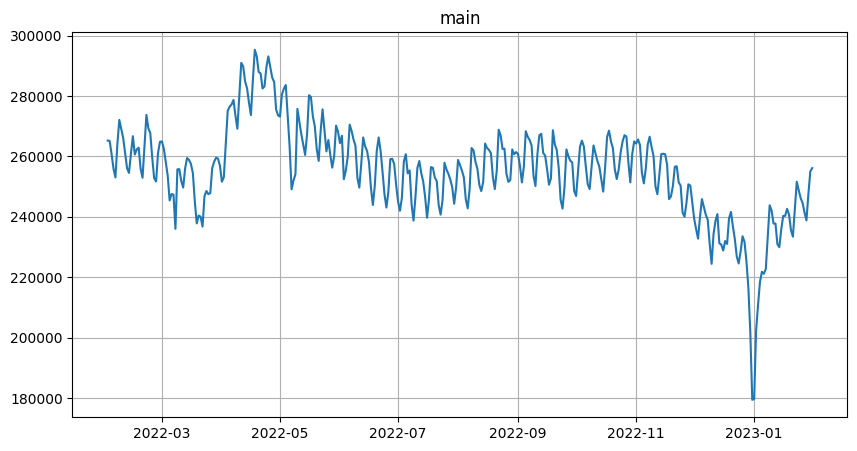

In [ ]:
data_dayly.plot()

In [ ]:
print(f"количество объявлений экстремально низкое: {data.iloc[data.target.argmin(), 0].strftime('%Y-%m-%d')}")

количество объявлений экстремально низкое: 2022-12-31


## Задание 2. Обработка выбросов (1/2)
Теперь займемся обработкой выбросов. С помощью `get_anomalies_prediction_interval` постройте график аномалий, которые выделит `Prophet` модель (воспользуйтесь кодом из лекции). Ширину интервала установите равной `99.9%`.

Зафиксируйте в ячейке с построением графика `np.random.seed(42)`

Сколько точек было определено как выбросы?

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/9ynu8jyt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/0jf783he.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78388', 'data', 'file=/tmp/tmp0vljl359/9ynu8jyt.json', 'init=/tmp/tmp0vljl359/0jf783he.json', 'output', 'file=/tmp/tmp0vljl359/prophet_model9ocjp3zm/prophet_model-20240825093752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:37:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


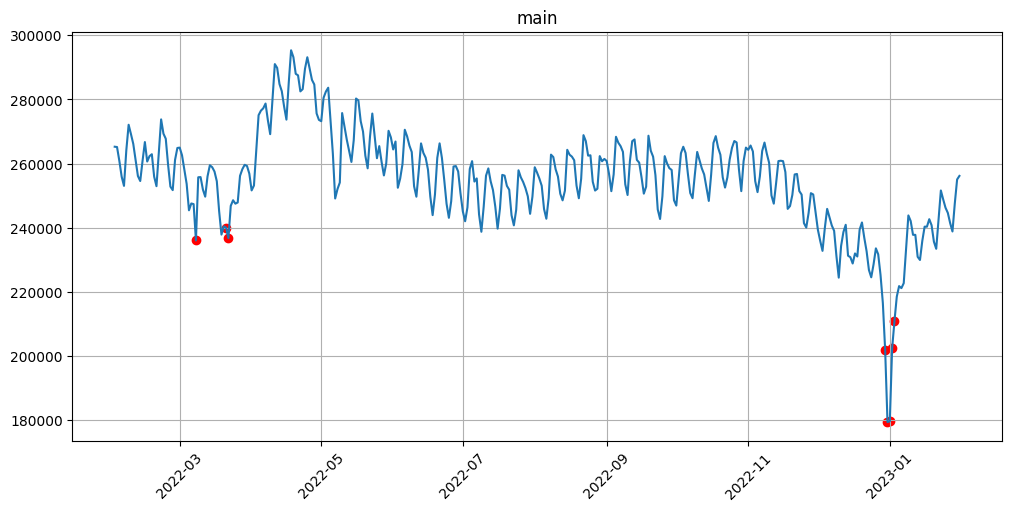

In [ ]:
np.random.seed(42)
anomalies_model = get_anomalies_prediction_interval(
    data_dayly, model=ProphetModel, interval_width=0.999,
)

plot_anomalies(data_dayly, anomalies_model)

In [ ]:
print(f'количество точек было определено как выбросы: {len(anomalies_model.get("main"))}')

количество точек было определено как выбросы: 8


## Задание 2. Обработка выбросов (2/2)
Посмотрим, как изменится наш таргет, если удалить наблюдения с выбросами. Возьмите точки из предыдущего степа и посчитайте среднюю целевой переменной без них.

Введите значение, округленное до целого числа, в поле ниже.

Обратите внимание, что в следующих степах мы будем работать с неизмененным временным рядом.

А процесс поиска выбросов и замены их на скользящее среднее мы реализуем в рамках пайплайна препроцессинга, перед обучением некоторых моделей.

In [ ]:
anomalies_dates = pd.to_datetime(anomalies_model.get("main")).to_list()

In [ ]:
data.query("timestamp not in @anomalies_dates")

,timestamp,target,segment
0,2022-02-01,265260,main
1,2022-02-02,265165,main
2,2022-02-03,260833,main
3,2022-02-04,255914,main
4,2022-02-05,253061,main
...,...,...,...
360,2023-01-27,241452,main
361,2023-01-28,238837,main
362,2023-01-29,247541,main
363,2023-01-30,255049,main


In [ ]:
print(f"средняя целевой переменной без выбросов = {data.query('timestamp not in @anomalies_dates').target.mean():.0f}")

средняя целевой переменной без выбросов = 256114


## Задание 3. Проверка на наличие тренда
С помощью функции `plot_trend` постройте график ряда и его линейный тренд.

Какой знак у коэффициента наклона прямой тренда?

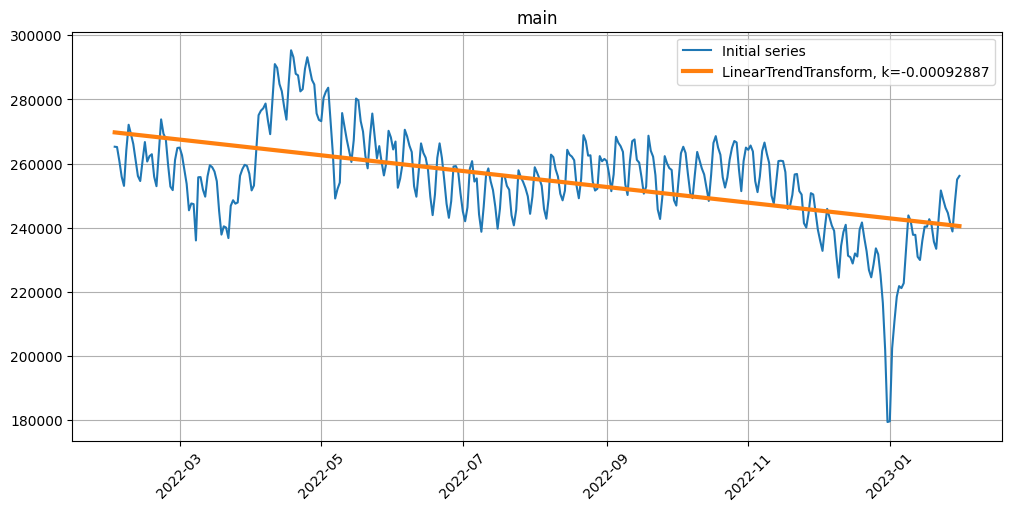

In [ ]:
plot_trend(ts=data_dayly, trend_transform=LinearTrendTransform(in_column="target"))

## Задание 4. Выбор модели (1/7)
Постройте график автокорреляции ряда до 30 лага.

Как вы думаете, почему график такой "волнистый"?

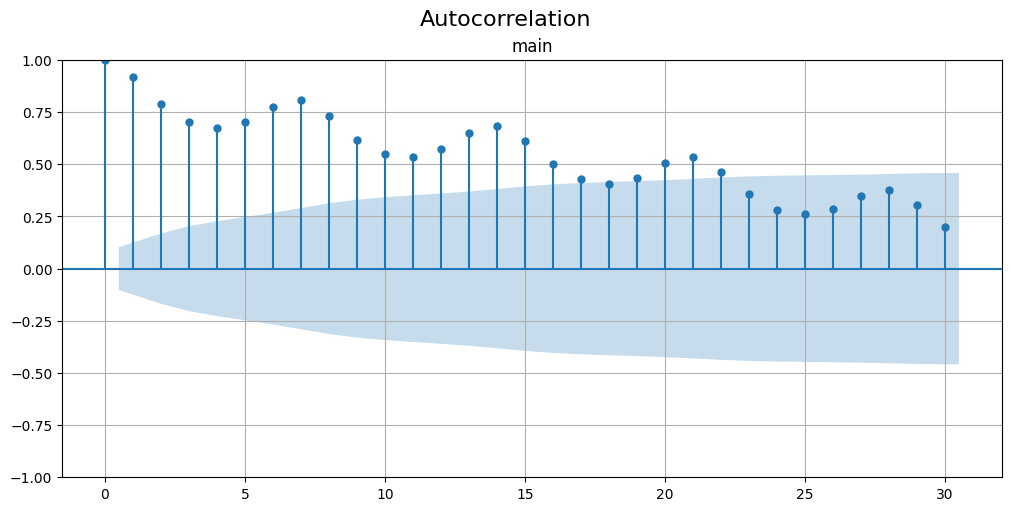

In [ ]:
acf_plot(data_dayly, lags=30)

из-за сезонности

## Задание 4. Выбор модели (2/7)
Каков наибольший порядок лага, для которого значима автокорреляция с текущим значением ряда?

In [ ]:
22

22

## Задание 4. Выбор модели (3/7)
Поисследуем наши данные на стационарность. Проведите расширенный `тест Дики-Фуллера`с константой и трендом (тут вам поможет документация).

Какое получилось значение `adf-статистики`?

Введите значение в поле ниже, округленное до двух знаков в десятичной части.



In [ ]:
result = adfuller(data_dayly.to_pandas()[('main', 'target')], regression='ct',)

In [ ]:
print(f"значение adf-статистики = {result[0]:.2f}")

значение adf-статистики = -2.99


In [ ]:
p_value = result[1]

In [ ]:
# H0 - ряд не стационарен
print("ряд стационарен" if p_value < 0.05 else "ряд не стационарен")

ряд не стационарен


## Задание 4. Выбор модели (5/7)
Изобразите на графике ряд в первых разностях.

Какова минимальная и максимальная разность в количестве объявлений между соседними днями?

Введите оба значения в поле ниже, разделенные запятой и пробелом.

Пример: -128, 127

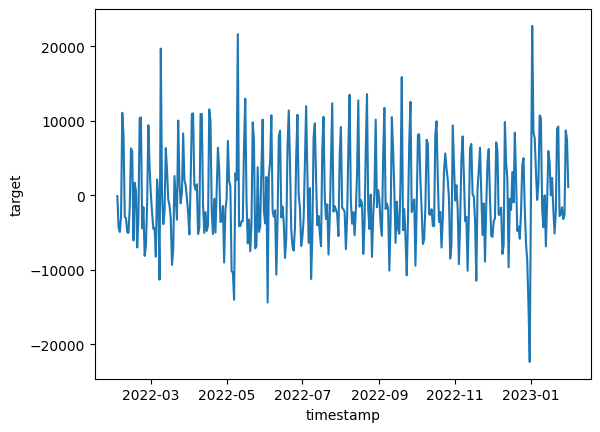

In [ ]:
#data.target.diff().plot()
sns.lineplot(x=data.timestamp, y=data.target.diff());

In [ ]:
print("минимальная и максимальная разность в количестве объявлений между соседними днями:")
print(f"{data.target.diff().min():.0f}, {data.target.diff().max():.0f}")

минимальная и максимальная разность в количестве объявлений между соседними днями:
-22367, 22743


## Задание 4. Выбор модели (6/7)
Для ряда из предыдущего степа проведите снова тест Дики-Фуллера. В данном случае уже не нужно учитывать тренд.

Какое получилось значение adf-статистики?

Введите значение в поле ниже, округленное до двух знаков в десятичной части.

In [ ]:
result = adfuller(data.target.diff()[1:], regression='c',)
print(f"значение adf-статистики = {result[0]:.2f}")

значение adf-статистики = -4.76


## Задание 4. Выбор модели (7/7)
Можем ли мы утверждать, что ряд в первых разностях стационарен?

In [ ]:
p_value = result[1]
print(f'p-value = {p_value:.5f}')
# H0 - ряд не стационарен
print("ряд стационарен" if p_value < 0.05 else "ряд не стационарен")

p-value = 0.00007
ряд стационарен


## Задание 5. Подготовка к валидации
С этого момента и далее давайте будем использовать не всю выборку, а ее часть. Мы видим, что у нас есть сильный выброс 2022-12-31 и 2023-01-01,
так что ошибка на этих днях будет нам все портить. Поэтому будем делать бэктесты и считать ошибку на данных до `2022-12-25`.

Разделить датасет можно с помощью `train_test_split` из `etna`.

Сколько осталось наблюдений?

In [ ]:
train_data_daily, test_data_daily = data_dayly.train_test_split(
    train_start=data.timestamp.min(),
    train_end="2022-12-25",
    test_start="2022-12-25",
    test_end=data.timestamp.max(),
)

In [ ]:
print(f"осталось {train_data_daily.to_pandas().size} наблюдений")

осталось 328 наблюдений


## Задание 6. Обучение наивной и авторегрессионной модели
Мы провели некоторые эксперименты, и теперь пришло время написать пайплайн. Попробуем сначала предсказывать ряд на одну неделю вперед.

1. Для начала обучите наивную модель, в которой мы предполагаем, что количество объявлений сегодня будет таким же, как вчера.

2. Обучите наивную модель, включив следующие преобразования:

* детекцию выбросов через `PredictionIntervalOutliersTransform` c `Prophet`-моделью и шириной интервала `99.9%`
* замену выбросов с помощью скользящего среднего окна в `7 дней`
* выделение линейного тренда
3. Обучите `ARIMA-модель без преобразований`.

4. Обучите `ARIMA-модель с трансформами из пункта 2`

Для всех четырех случаев сделайте `backtest на 10 фолдах` и посчитайте `среднее SMAPE по фолдам`.

Какая модель дает наименьшую ошибку?

In [ ]:
from etna.analysis import plot_forecast

### NaiveModel

In [ ]:
SMAPEs = dict()

In [ ]:
pipeline_naive = Pipeline(model=NaiveModel(lag=1), transforms=[], horizon=7)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

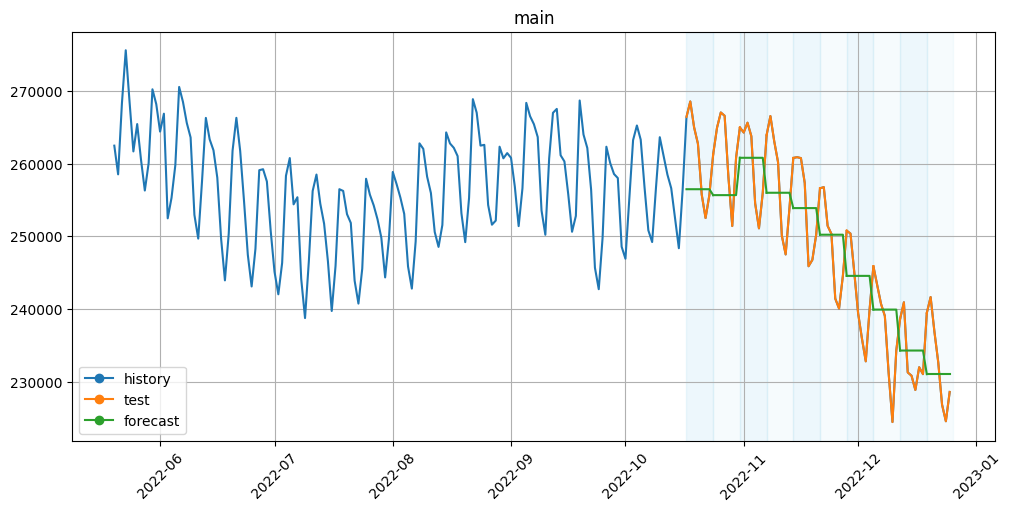

In [ ]:
metrics_df, forecast_df, fold_info_df = pipeline_naive.backtest(
    ts=train_data_daily, metrics=[SMAPE()], n_folds=10
)

SMAPEs['pipeline_naive'] = metrics_df.SMAPE.mean()
plot_backtest(forecast_df, train_data_daily, history_len=150)

### NaiveModel with transformers

In [ ]:
transforms = [
    PredictionIntervalOutliersTransform(model=ProphetModel, interval_width=0.999, in_column='target'),
    TimeSeriesImputerTransform(strategy="running_mean", window=7, in_column='target'),
    LinearTrendTransform(in_column="target"),
]

In [ ]:
pipeline_naive_w_transforms = Pipeline(
    model=NaiveModel(lag=1),
    transforms=transforms, horizon=7
)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/nmv2s3_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/wy87o06s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2186', 'data', 'file=/tmp/tmp0vljl359/nmv2s3_3.json', 'init=/tmp/tmp0vljl359/wy87o06s.json', 'output', 'file=/tmp/tmp0vljl359/prophet_modeltbbgh1xs/prophet_model-20240825093800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:38:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks     

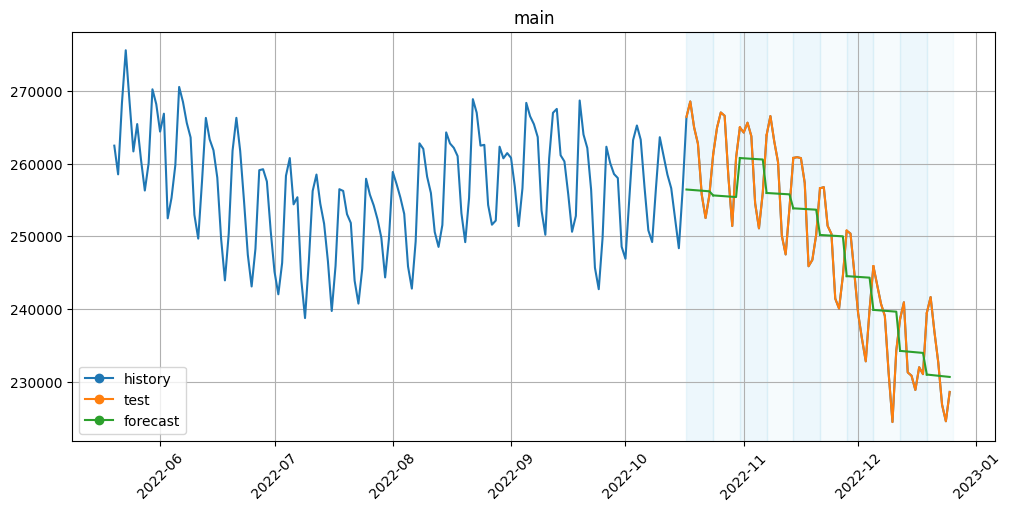

In [ ]:
metrics_df, forecast_df, fold_info_df = pipeline_naive_w_transforms.backtest(
    ts=train_data_daily, metrics=[SMAPE()], n_folds=10
)

SMAPEs['pipeline_naive_w_transforms'] = metrics_df.SMAPE.mean()
plot_backtest(forecast_df, train_data_daily, history_len=150)

### AutoARIMAModel

In [ ]:
arima_pipe = Pipeline(model=AutoARIMAModel(), transforms=[], horizon=7)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   11.3s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:   12.4s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:   13.6s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:   15.0s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:   15.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Do

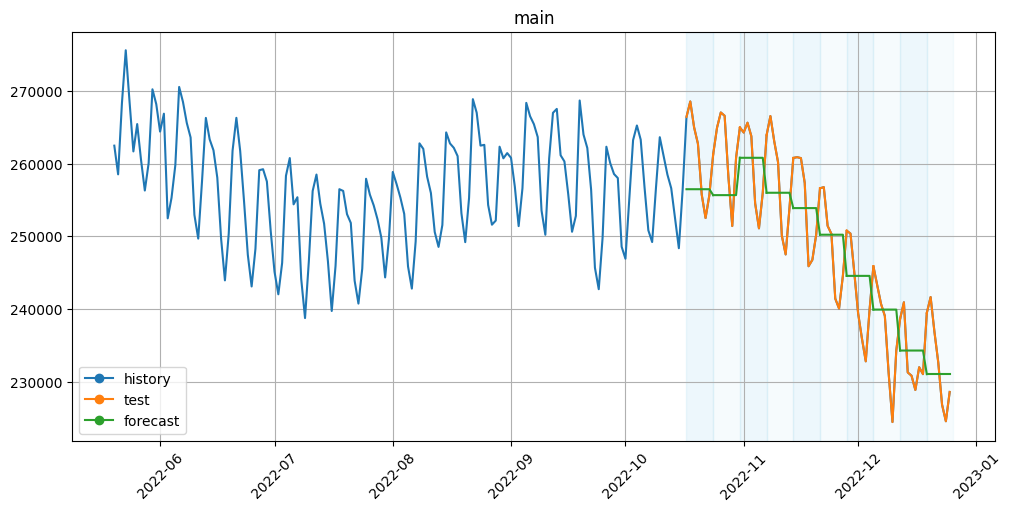

In [ ]:
metrics_df, forecast_df, fold_info_df = arima_pipe.backtest(
    ts=train_data_daily, metrics=[SMAPE()], n_folds=10
)
SMAPEs['arima_pipe'] = metrics_df.SMAPE.mean()
plot_backtest(forecast_df, train_data_daily, history_len=150)

### AutoARIMAModel with transforms

In [ ]:
arima_pipe_w_transforms = Pipeline(model=AutoARIMAModel(), transforms=transforms, horizon=7)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/1u2p7s02.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/cbv33dvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36964', 'data', 'file=/tmp/tmp0vljl359/1u2p7s02.json', 'init=/tmp/tmp0vljl359/cbv33dvv.json', 'output', 'file=/tmp/tmp0vljl359/prophet_model0tc5kt5p/prophet_model-20240825093831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:38:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks    

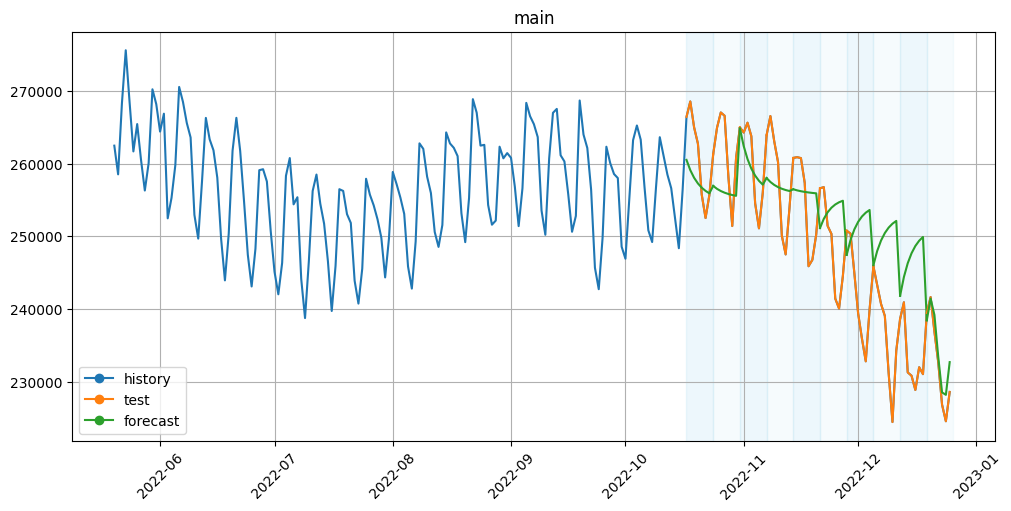

In [ ]:
metrics_df, forecast_df, fold_info_df = arima_pipe_w_transforms.backtest(
    ts=train_data_daily, metrics=[SMAPE()], n_folds=10
)
SMAPEs['arima_pipe_w_transforms'] = metrics_df.SMAPE.mean()
plot_backtest(forecast_df, train_data_daily, history_len=150)

### Сравнение качества моделей

In [ ]:
SMAPEs

{'pipeline_naive': 2.3383556582127967,
 'pipeline_naive_w_transforms': 2.3179801436078113,
 'arima_pipe': 2.3383556582127967,
 'arima_pipe_w_transforms': 2.930259617121858}

### Задание 6. Обучение линейных моделей (1/2)

Вспомним график `ACF`. Ряд явно является авторегрессионным – есть значимая зависимость текущего значения от предыдущих.

Воспользуемся `AutoRegressivePipeline`. Давайте добавим лаги от `7-го до 15-го` включительно в трансформы нашей модели через `LagTransform`.

Почему мы не можем добавить лаги с 1 по 6?

In [ ]:
# Они будут объектами предсказания и не могут служить основой для дальнейших прогнозов

## Задание 6. Обучение линейных моделей (2/2)
Помимо лагов добавьте также все трансформы из предыдущего задания (тренд + обработку выбросов).Т.о. в списке трансформов будут
* PredictionIntervalOutliersTransform,
* TimeSeriesImputerTransform,
* LinearTrendTransform,
* LagTransform.

В `etna` много разных моделей, в том числе из других библиотек. На уроке вы рассмотрели `Prophet-модель`. Есть еще одна сильная модель - `CatBoost`, разработка Яндекса. Это линейная модель для задач регрессии и классификации, которая построена на решающих деревьях (тоже ML-алгоритме). Мы можем спокойно использовать известные нам модели линейной регрессии и на time series данных, только в этом случае нашими фичами будут лаги (и экзогенные переменные), и мы не будем перемешивать выборку при сплите на трейн и тест. Но здесь нам не нужно беспокоиться об этом: etna умеет работать и с линейными моделями тоже.

Итак, давайте сравним несколько линейных моделей:

1. обычную линейку LinearPerSegmentModel
2. CatBoostPerSegmentModel
3. ProphetModel
Не забудьте добавить трансформы!

Вновь сделайте `бэктэст на 10 фолдах` и посчитайте среднее `SMAPE`.

Отметьте топ-2 модели по качеству предсказания

In [ ]:
from etna.transforms import TimeSeriesImputerTransform, LinearTrendTransform, LagTransform
from etna.models import LinearPerSegmentModel
from etna.pipeline import AutoRegressivePipeline

### AutoRegressivePipeline + LinearPerSegmentModel

In [ ]:
transforms = [
    PredictionIntervalOutliersTransform(model=ProphetModel, interval_width=0.999, in_column='target'),
    TimeSeriesImputerTransform(strategy="running_mean", window=7, in_column='target'),
    LinearTrendTransform(in_column="target"),
    LagTransform(lags=list(range(7, 16)), in_column='target'),
]

In [ ]:
auto_linearpersegmentmodel_pipe = AutoRegressivePipeline(model=LinearPerSegmentModel(), transforms=transforms, horizon=7)

In [ ]:
SMAPEs = dict()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/48vxxrzl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/psiak0yk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19642', 'data', 'file=/tmp/tmp0vljl359/48vxxrzl.json', 'init=/tmp/tmp0vljl359/psiak0yk.json', 'output', 'file=/tmp/tmp0vljl359/prophet_modelinxp8fui/prophet_model-20240825093919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:39:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:39:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks    

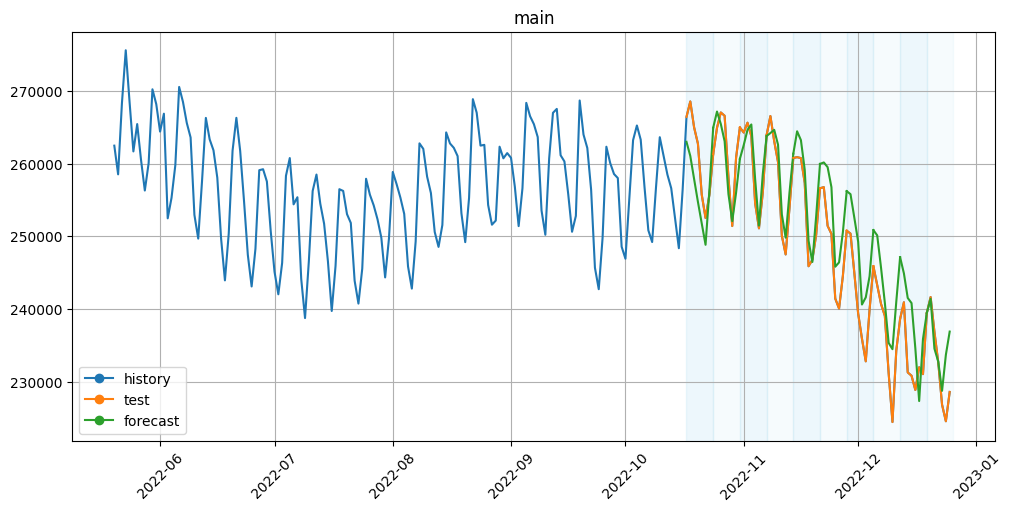

In [ ]:
metrics_df, forecast_df, fold_info_df = auto_linearpersegmentmodel_pipe.backtest(
    ts=train_data_daily, metrics=[SMAPE()], n_folds=10
)
SMAPEs['auto_linearpersegmentmodel_pipe'] = metrics_df.SMAPE.mean()
plot_backtest(forecast_df, train_data_daily, history_len=150)

In [ ]:
SMAPEs

{'auto_linearpersegmentmodel_pipe': 1.681114975091552}

### AutoRegressivePipeline + CatBoostPerSegmentModel

In [ ]:
auto_catboostpersegmentmodel_pipe = AutoRegressivePipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=7)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/6nejod6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/x77albrl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10920', 'data', 'file=/tmp/tmp0vljl359/6nejod6b.json', 'init=/tmp/tmp0vljl359/x77albrl.json', 'output', 'file=/tmp/tmp0vljl359/prophet_modely_pp_brp/prophet_model-20240825093934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:39:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:39:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks    

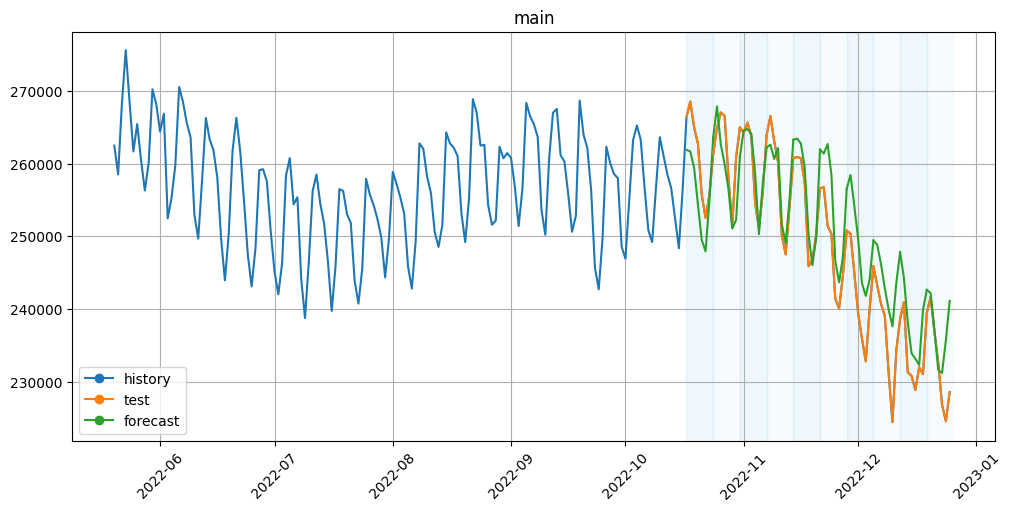

In [ ]:
metrics_df, forecast_df, fold_info_df = auto_catboostpersegmentmodel_pipe.backtest(
    ts=train_data_daily, metrics=[SMAPE()], n_folds=10
)
SMAPEs['auto_catboostpersegmentmodel_pipe'] = metrics_df.SMAPE.mean()
plot_backtest(forecast_df, train_data_daily, history_len=150)

### AutoRegressivePipeline + ProphetModel

In [ ]:
auto_prophetmodel_pipe = AutoRegressivePipeline(model=ProphetModel(), transforms=transforms, horizon=7)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/1t8m218f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/tjfchvcy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15001', 'data', 'file=/tmp/tmp0vljl359/1t8m218f.json', 'init=/tmp/tmp0vljl359/tjfchvcy.json', 'output', 'file=/tmp/tmp0vljl359/prophet_model6cdu995f/prophet_model-20240825094017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

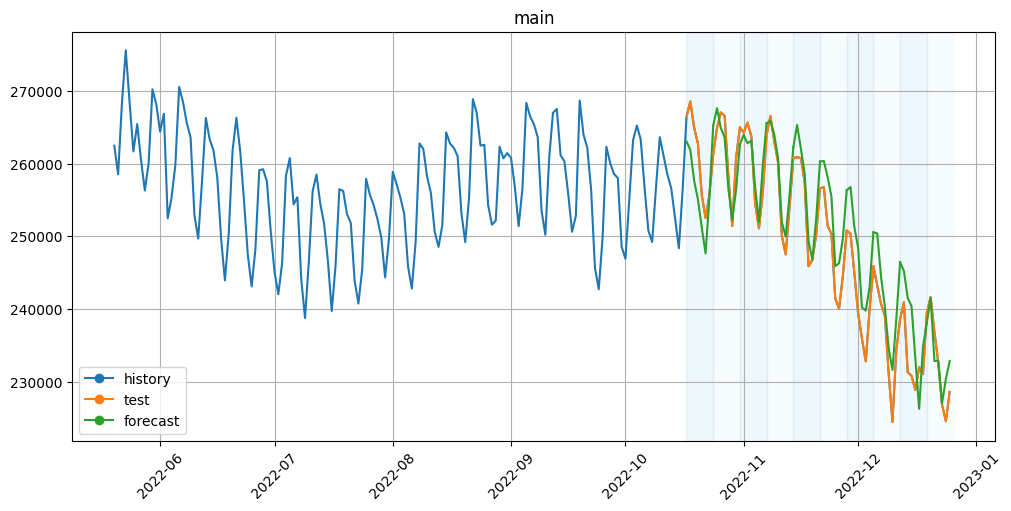

In [ ]:
metrics_df, forecast_df, fold_info_df = auto_prophetmodel_pipe.backtest(
    ts=train_data_daily, metrics=[SMAPE()], n_folds=10
)
SMAPEs['auto_prophetmodel_pipe'] = metrics_df.SMAPE.mean()
plot_backtest(forecast_df, train_data_daily, history_len=150)

### Оценка качества моделей

In [ ]:
SMAPEs

{'auto_linearpersegmentmodel_pipe': 1.681114975091552,
 'auto_catboostpersegmentmodel_pipe': 1.8366908206284722,
 'auto_prophetmodel_pipe': 1.5059971462783595}

## Задание 7. Новый горизонт прогнозирования (1/2)
Давайте возьмем топ-2 модели по качеству, увеличим горизонт до месяца (`30 дней`) и посмотрим, как они себя покажут.

Сделайте `бэктест на 5 фолдов`. Не забудьте, что нам нужно поменять порядок лагов: давайте теперь включим `лаги с 31 по 45`. Оставьте все остальные трансформы из предыдущих пунктов.

Зафиксируйте `np.random.seed(42)` в каждой ячейке с обучением модели

Какая ошибка у лучшей модели?

Введите значение в поле ниже с точностью до двух знаков в десятичной части.

### AutoRegressivePipeline + LinearPerSegmentModel

In [ ]:
transforms = [
    PredictionIntervalOutliersTransform(model=ProphetModel, interval_width=0.999, in_column='target'),
    TimeSeriesImputerTransform(strategy="running_mean", window=7, in_column='target'),
    LinearTrendTransform(in_column="target"),
    LagTransform(lags=list(range(31, 46)), in_column='target', out_column='target_lag'),
]

In [ ]:
np.random.seed(42)
auto_linearpersegmentmodel_pipe = AutoRegressivePipeline(model=LinearPerSegmentModel(), transforms=transforms, horizon=30)

In [ ]:
SMAPEs = dict()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/4i20y2ko.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/qvkvxdn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81099', 'data', 'file=/tmp/tmp0vljl359/4i20y2ko.json', 'init=/tmp/tmp0vljl359/qvkvxdn3.json', 'output', 'file=/tmp/tmp0vljl359/prophet_modeldmfh5ed2/prophet_model-20240825102522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:25:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:25:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks    

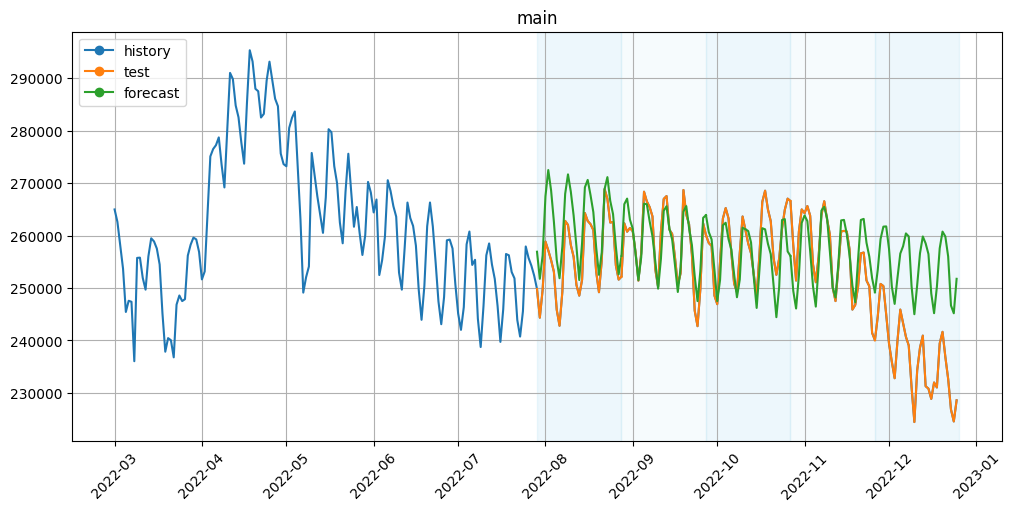

In [ ]:
np.random.seed(42)
metrics_df, forecast_df, fold_info_df = auto_linearpersegmentmodel_pipe.backtest(
    ts=train_data_daily, metrics=[SMAPE()], n_folds=5
)
SMAPEs['auto_linearpersegmentmodel_pipe'] = metrics_df.SMAPE.mean()
plot_backtest(forecast_df, train_data_daily, history_len=150)

### AutoRegressivePipeline + ProphetModel

In [ ]:
auto_prophetmodel_pipe = AutoRegressivePipeline(model=ProphetModel(), transforms=transforms, horizon=30)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/bs0mkqc1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0vljl359/6xwe0cju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20534', 'data', 'file=/tmp/tmp0vljl359/bs0mkqc1.json', 'init=/tmp/tmp0vljl359/6xwe0cju.json', 'output', 'file=/tmp/tmp0vljl359/prophet_modelcda3oj20/prophet_model-20240825102547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:25:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:25:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

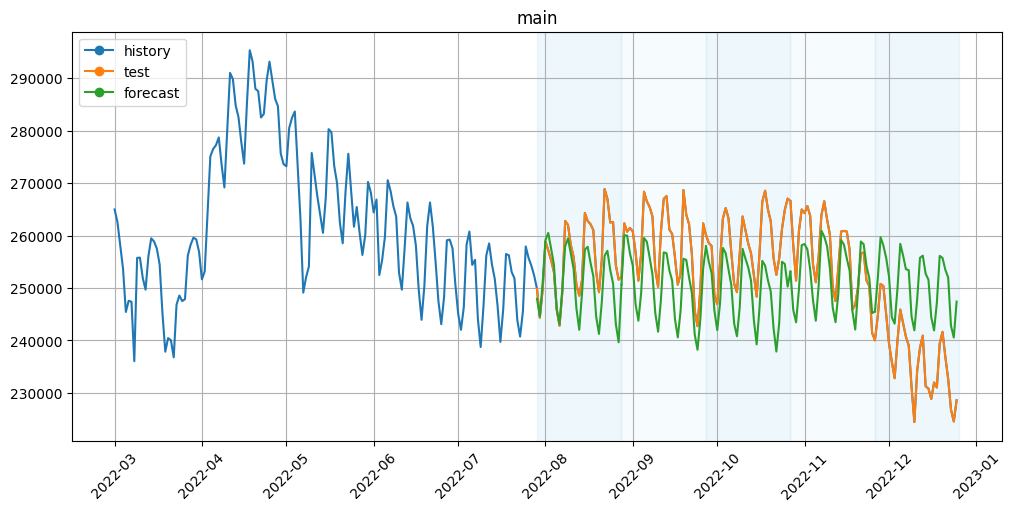

In [ ]:
np.random.seed(42)
metrics_df, forecast_df, fold_info_df = auto_prophetmodel_pipe.backtest(
    ts=train_data_daily, metrics=[SMAPE()], n_folds=5
)
SMAPEs['auto_prophetmodel_pipe'] = metrics_df.SMAPE.mean()
plot_backtest(forecast_df, train_data_daily, history_len=150)

### Оценка качества моделей

In [ ]:
SMAPEs

{'auto_linearpersegmentmodel_pipe': 2.658692249516026,
 'auto_prophetmodel_pipe': 3.26129455679443}

In [ ]:
SMAPEs["auto_linearpersegmentmodel_pipe"].round(2)

2.66